<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/CNN_MLAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, default_collate
import torchvision.transforms as transforms

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
!wget -O US_Pictures.zip https://zenodo.org/record/7669442/files/US_Pictures.zip?download=1
!unzip -q US_Pictures.zip -d /content/US_Pictures/

print(os.listdir('/content/US_Pictures/'))

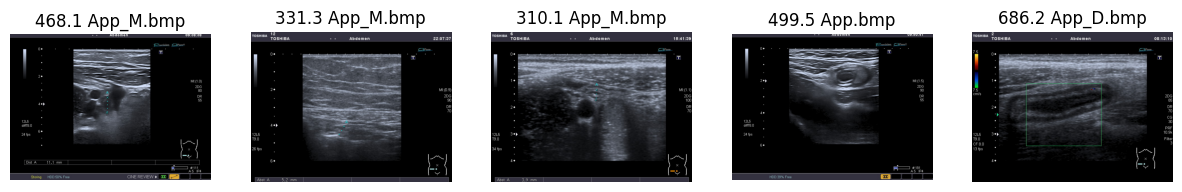

In [4]:
def display_images(image_path, num_images=5):
    # Ensure the function handles no image files gracefully
    files = [f for f in os.listdir(image_path) if f.endswith(('.png', '.bmp'))][:num_images]
    if not files:
        print("No image files found in the directory.")
        return

    fig, axs = plt.subplots(1, len(files), figsize=(15, 5))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_path, file))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(file)
    plt.show()

display_images('/content/US_Pictures/US_Pictures/')

In [5]:
# Load the data
data_url = "https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv"
tabular_data = pd.read_csv(data_url, delimiter= ';')

In [6]:
# deleting not needed target variables from data
data = tabular_data.drop(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
                          'Severity', 'Diagnosis_Presumptive', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score',
                          'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
                          'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
                          'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils',
                          'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'Ketones_in_Urine',
                          'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis',
                          'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
                          'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation',
                          'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Abscess_Location',
                          'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening',
                          'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis',
                          'Gynecological_Findings', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60','Unnamed: 61',
                          'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66','Unnamed: 67',
                          'Unnamed: 68'], axis=1)

# Diagnosis
data["Diagnosis"] = data["Diagnosis"].replace({'appendicitis': 1, 'no appendicitis': 0, })
data['Diagnosis'] = data['Diagnosis'].replace({np.nan: 0})

# removing all NAN values from US_Number
data = data.dropna(subset=['US_Number'])

# Convert 'US_Number' and 'Diagnosis' columns to integers
data['US_Number'] = data['US_Number'].astype(int)
data['Diagnosis'] = data['Diagnosis'].astype(int)

# Print the data to verify the conversion
print(data.head())

   Diagnosis  US_Number
0          1        882
1          0        883
2          0        884
3          0        886
4          1        887


In [7]:
# Creating id_to_label and ensuring keys are strings
id_to_label = {int(row['US_Number']): row['Diagnosis'] for index, row in data.iterrows() if pd.notna(row['US_Number'])}

print(id_to_label)

{882: 1, 883: 0, 884: 0, 886: 0, 887: 1, 888: 0, 889: 0, 890: 0, 891: 0, 893: 1, 894: 1, 895: 0, 896: 0, 897: 0, 900: 1, 903: 0, 904: 1, 905: 1, 909: 1, 910: 0, 911: 1, 913: 0, 914: 0, 916: 0, 917: 0, 918: 1, 921: 1, 922: 0, 924: 1, 925: 1, 926: 0, 927: 1, 928: 1, 929: 0, 930: 1, 931: 0, 933: 1, 934: 0, 935: 1, 936: 1, 938: 1, 939: 1, 940: 0, 942: 0, 943: 0, 945: 0, 946: 0, 947: 1, 948: 0, 949: 0, 950: 1, 951: 0, 952: 0, 953: 1, 954: 0, 955: 1, 959: 0, 961: 0, 962: 0, 963: 0, 965: 1, 967: 0, 968: 0, 971: 0, 973: 1, 974: 1, 976: 0, 977: 0, 978: 0, 981: 1, 982: 0, 983: 0, 986: 0, 988: 0, 989: 1, 991: 0, 992: 1, 733: 1, 735: 1, 736: 0, 737: 0, 738: 1, 739: 0, 740: 1, 743: 0, 745: 0, 746: 1, 748: 1, 749: 1, 750: 1, 751: 1, 752: 1, 753: 0, 754: 0, 755: 0, 756: 1, 757: 0, 759: 1, 760: 0, 761: 1, 765: 0, 769: 0, 771: 1, 772: 1, 775: 1, 777: 1, 779: 0, 780: 0, 781: 1, 782: 0, 786: 0, 787: 0, 789: 0, 790: 1, 791: 1, 794: 0, 795: 0, 796: 0, 797: 1, 799: 0, 801: 1, 802: 1, 803: 0, 804: 0, 805: 0,

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input channels = 3 (RGB), output channels = 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust the input features to match your image size
        self.fc2 = nn.Linear(512, 2)  # Output layer: adjust according to the number of classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
)


In [29]:
from collections import defaultdict, Counter

class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image files.
            labels_dict (dict): Dictionary mapping image file names to labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.filename_mapping = {}
        self.unique_us_numbers = set()
        self.diagnosis_count_per_image = defaultdict(int)
        self.diagnosis_count_per_us_number = defaultdict(Counter)

        num_images_found = 0
        table_data = []

        # Create a mapping between full filenames and image data
        for filename in os.listdir(root_dir):
            num_images_found += 1
            try:
                # Extract the image number from the filename
                image_number = int(filename.split('.')[0])
                # Use the image number as a key to get the corresponding label from labels_dict
                label = labels_dict.get(image_number)

                if label is not None:  # Only proceed if a valid label exists
                    self.unique_us_numbers.add(image_number)
                    self.diagnosis_count_per_image[label] += 1  # Increment the count for the diagnosis
                    # Track only the first occurrence of a US_Number for a given diagnosis
                    if image_number not in self.diagnosis_count_per_us_number or label not in self.diagnosis_count_per_us_number[image_number]:
                        self.diagnosis_count_per_us_number[image_number][label] += 1

                    image = Image.open(os.path.join(root_dir, filename)).convert('RGB')
                    if self.transform: # Load the image and convert to tensor
                        image = self.transform(image)
                    # Store the tensor along with the full filename
                    self.filename_mapping[filename] = (image, label)
                    self.unique_us_numbers.add(image_number)
                    table_data.append((image_number, filename, label, type(image_number)))
            except ValueError:
                # This handles cases where the filename does not start with an integer
                print(f"Skipping file with non-standard naming: {filename}")

        # Sort the table data by the "Image Number" column
        sorted_table_data = sorted(table_data, key=lambda x: x[0])

        # Print the sorted table using tabulate after iterating over all images
        # print(tabulate(sorted_table_data, headers=['Image Number', 'Filename', 'Diagnosis', 'Type']))
        print(f"Total images found before matching: {num_images_found}")
        print(f"Total images successfully mapped to a US_NUMBER: {len(self.filename_mapping)}")
        print(f"Total us_numbers successfully mapped to images: {len(self.unique_us_numbers)}")

        for diagnosis, count in self.diagnosis_count_per_image.items():
            print(f"Diagnosis {diagnosis}: {count} images")

        # Summing counts across all US_Numbers for each diagnosis
        total_diagnosis_counts = defaultdict(int)
        for us_number, counts in self.diagnosis_count_per_us_number.items():
            for diagnosis, count in counts.items():
                total_diagnosis_counts[diagnosis] += count

        for diagnosis, count in total_diagnosis_counts.items():
            print(f"Diagnosis {diagnosis}: {count} unique US_NUMBERs")

    def __len__(self):
        return len(self.filename_mapping)

    def __getitem__(self, idx):
        # Retrieve the data point using the filename mapping
        filename = list(self.filename_mapping.keys())[idx]
        image, label = self.filename_mapping[filename]
        return image, label, filename


In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizse
])

dataset = MedicalImagesDataset('/content/US_Pictures/US_Pictures/', id_to_label, transform)


Total images found before matching: 2097
Total images successfully mapped to a US_NUMBER: 1727
Total us_numbers successfully mapped to images: 579
Diagnosis 1: 1339 images
Diagnosis 0: 388 images
Diagnosis 1: 382 unique US_NUMBERs
Diagnosis 0: 197 unique US_NUMBERs


In [11]:
# Print first entries of the dataset to inspect their structure
for idx in range(1):
    print(dataset[idx])

(tensor([[[-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         [-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         [-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         ...,
         [-1.2274, -1.2274, -1.2274,  ..., -2.0323, -2.0323, -1.4672],
         [-1.2274, -1.2274, -1.2274,  ..., -0.6281, -0.6281, -0.5767],
         [-1.2274, -1.2274, -1.2274,  ..., -1.2274, -1.2274, -1.2274]],

        [[-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         [-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         [-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         ...,
         [-1.1604, -1.1604, -1.1604,  ..., -1.9482, -1.9482, -1.3704],
         [-1.1604, -1.1604, -1.1604,  ..., -0.5301, -0.5301, -0.4951],
         [-1.1604, -1.1604, -1.1604,  ..., -1.1604, -1.1604, -1.1604]],

        [[-0.7064, -0.7064, -0.7064,  ..., -0.7064, -0.7064, -0.7064],
         [-0.7064, -0.7064, -0.7064,  ..., -

In [12]:
us_numbers = []
labels = []

# Loop over each entry in the filename mapping
for filename, (image, label) in dataset.filename_mapping.items():
    image_number = int(filename.split('.')[0])
    us_numbers.append(image_number)
    labels.append(label)

# Convert lists to numpy arrays for proper indexing
us_numbers = np.array(us_numbers)
labels = np.array(labels)

# Create the splitter
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get indices for the splits
train_inds, val_inds = next(gss.split(X=labels, groups=us_numbers))

# Extract datasets for training and validation using list comprehension
train_dataset = [dataset[i] for i in train_inds]
val_dataset = [dataset[i] for i in val_inds]

# Create DataLoader for both training and validation sets
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [25]:
# Collect filenames and labels from train_dataset
train_filenames = [filename for _, label, filename in train_dataset]
train_labels = [label for _, label, filename in train_dataset]

# Collect filenames and labels from val_dataset
val_filenames = [filename for _, label, filename in val_dataset]
val_labels = [label for _, label, filename in val_dataset]

# Create DataFrames
train_df = pd.DataFrame({
    'Filename': train_filenames,
    'Label': train_labels
})

val_df = pd.DataFrame({
    'Filename': val_filenames,
    'Label': val_labels
})

# Sort by Filename
train_df_sorted = train_df.sort_values(by='Filename', ascending=True)
val_df_sorted = val_df.sort_values(by='Filename', ascending=True)

print("Sorted Training Data:")
# print(train_df_sorted)


Sorted Training Data:


In [26]:
print("\nSorted Validation Data:")
# print(val_df_sorted)


Sorted Validation Data:


In [15]:
# Count occurrences of each diagnosis in the training set
train_diagnosis_counts = train_df_sorted['Label'].value_counts()

# Count occurrences of each diagnosis in the validation set
val_diagnosis_counts = val_df_sorted['Label'].value_counts()

# Print the counts
print("Diagnosis Distribution in Training Data:")
print(train_diagnosis_counts)
print("\nDiagnosis Distribution in Validation Data:")
print(val_diagnosis_counts)

Diagnosis Distribution in Training Data:
Label
1    1063
0     293
Name: count, dtype: int64

Diagnosis Distribution in Validation Data:
Label
1    276
0     95
Name: count, dtype: int64


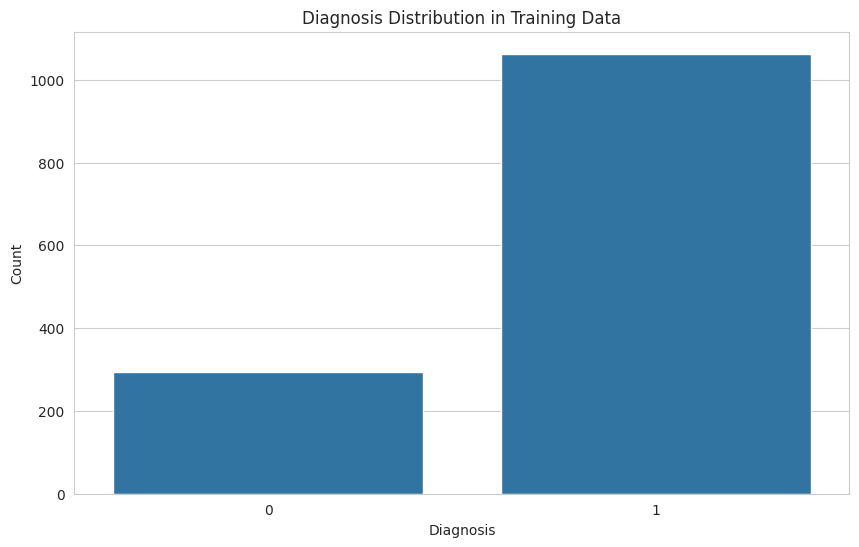

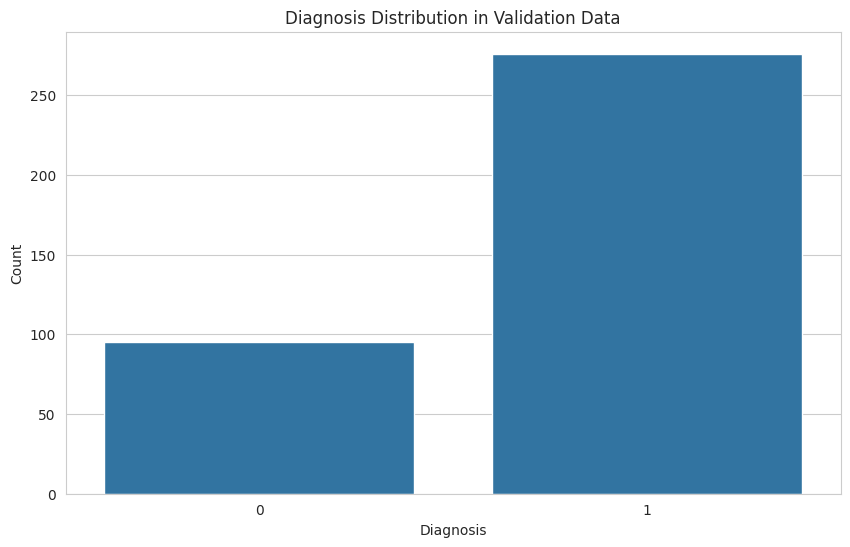

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot for Training Data
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=train_df_sorted)
plt.title('Diagnosis Distribution in Training Data')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Plot for Validation Data
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=val_df_sorted)
plt.title('Diagnosis Distribution in Validation Data')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [17]:
def custom_collate(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    filenames = [item[2] for item in batch]

    # Find the maximum sequence length in the batch
    max_sequence_length = max(len(image) for image in images)

    # Pad images to the same size
    padded_images = []
    for image_sequence in images:
        num_padding = max_sequence_length - len(image_sequence)
        padded_sequence = torch.nn.functional.pad(image_sequence, (0, num_padding))
        padded_images.append(padded_sequence)

    # Stack padded images
    stacked_images = torch.stack(padded_images)

    return stacked_images, torch.tensor(labels), filenames

# Use the custom collate function in your DataLoader
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# # Training loop
# num_epochs =
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for images, labels, filenames in dataloader:  # Now unpacking filenames as well
#         optimizer.zero_grad()  # Zero the parameter gradients
#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)
#         loss.backward()  # Backward pass
#         optimizer.step()  # Optimize the model

#         running_loss += loss.item()
#     print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}')

# print('Finished Training')


In [23]:
# Define loss function (criterion) and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)  # Example: Adam optimiser with learning rate 0.001

# Define a dataloader for the validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 20
best_validation_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels, filenames in dataloader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}')

    # Calculate validation loss
    validation_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels, _ in val_dataloader:
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()

    # Print epoch statistics
    average_train_loss = running_loss / len(val_dataloader)
    average_validation_loss = validation_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss}, Validation Loss: {average_validation_loss}')

    # Check for improvement in validation loss
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        patience_counter = 0
        # Save the model if validation loss improved
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Check if early stopping criteria met
    if patience_counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

print('Finished Training')


Epoch 1, Loss: 0.4976462458455285
Epoch 1, Train Loss: 1.7832323809464772, Validation Loss: 0.5586985970536867
Epoch 2, Loss: 0.4494909675315369
Epoch 2, Train Loss: 1.6106759669880073, Validation Loss: 0.6189676970243454
Epoch 3, Loss: 0.3875854895558468
Epoch 3, Train Loss: 1.3888480042417843, Validation Loss: 0.7142429749170939
Epoch 4, Loss: 0.28312352161074794
Epoch 4, Train Loss: 1.0145259524385135, Validation Loss: 0.8806696484486262
Epoch 5, Loss: 0.1944116712656132
Epoch 5, Train Loss: 0.6966418220351139, Validation Loss: 1.174098680416743
Epoch 6, Loss: 0.12038282149059829
Epoch 6, Train Loss: 0.4313717770079772, Validation Loss: 1.601911336183548
Early stopping after 6 epochs.
Finished Training


Validation Accuracy: 0.6819407008086253


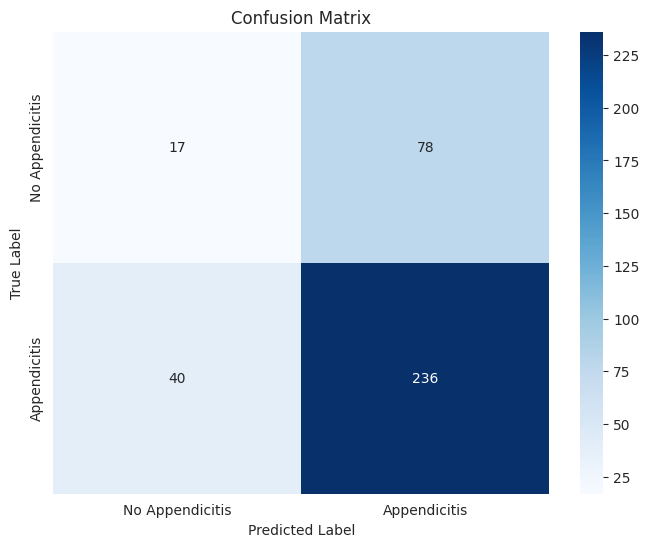

                                          Filename  Ground Truth  Prediction  \
0                                  468.1 App_M.bmp             1           1   
1                                    499.5 App.bmp             1           1   
2                                  643.4 App_M.bmp             0           1   
3                                    282.4 App.bmp             1           1   
4                                   97.1 App_M.bmp             1           0   
5                                    231.1 App.bmp             1           1   
6                                  270.1 App_M.bmp             1           1   
7                                   96.1 App_M.bmp             1           1   
8                                  570.3 App_M.bmp             1           1   
9                                  624.2 App_M.bmp             1           1   
10                                 215.2 App_M.bmp             1           1   
11                                 111.1

In [28]:
model.eval()

# Lists to store predictions, ground truth labels, and filenames
all_predictions = []
all_labels = []
all_filenames = []
all_outputs = []

# Iterate over the validation dataset
for images, labels, filenames in val_dataloader:
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class indices

        # Store predictions, labels, filenames, and outputs
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())
        all_filenames.extend(filenames)
        all_outputs.extend(outputs.tolist())

# Convert predictions and labels to numpy arrays for further analysis if needed
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = np.mean(all_predictions == all_labels)
print(f'Validation Accuracy: {accuracy}')

# Define class labels
class_labels = ['No Appendicitis', 'Appendicitis']
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Store each prediction along with filenames and outputs
predictions_data = []
for i in range(len(all_predictions)):
    predictions_data.append({'Filename': all_filenames[i],
                             'Ground Truth': all_labels[i],
                             'Prediction': all_predictions[i],
                             'Output': all_outputs[i]})
predictions_df = pd.DataFrame(predictions_data)
print(predictions_df)